### Model building

Here we build the DCGAN on the DeviantArt images we've downloaded to the `DATA_FOLDER` directory. The DCGAN is build around the one described in [this paper](https://arxiv.org/abs/1511.06434) and was inspired by the tutorials provided by [TensorFlow](https://www.tensorflow.org/tutorials/generative/dcgan) and [PyTorch](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html). Note that because the data you can pull from DevaintArt is quite scarce training the model requires a lot of epochs for acceptable results, making the model very prone to overfitting.

In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [2]:
tf.__version__

'2.6.0'

There's now a few folders that we can specify, it's fine to leave them on the default settings:
- DATA_FOLDER: the folder to get the data from that you mined in the data step
- PREDICTIONS_FOLDER: each epoch of training we'll save the predictions on a set of static seeds here, allowing you to generate a gif of the training process at the end
- LOSS_FOLDER: each epoch of training we'll save our loss chart to this folder, allowing you to generate a gif of the loss over time at the ed
- CHECKPOINTS_FOLDER: every 15 epochs, we'll save a checkpoint of our model here, allowing you reload its parameters at that epoch later

**NOTE**: This notebook cleans none of these folders on a subsequent run, if you want to start from scratch, empty the folders manually.

In [3]:
DATA_FOLDER = "data"
PREDICTIONS_FOLDER = "predictions"
LOSS_FOLDER = "loss"
CHECKPOINTS_FOLDER = "checkpoints"
BUFFER_SIZE = 60000
BATCH_SIZE = 128
INPUT_SIZE = 100
IMAGE_SHAPE = (64, 64, 3)

In [4]:
train_images = []
for file in np.sort(os.listdir(DATA_FOLDER)):
    try:
        img = PIL.Image.open(f"{DATA_FOLDER}/{file}")

        # We remove images with an alpha level as they mess with the model
        if img.mode == "RGBA":
            continue

        img = img.convert("RGB")
        img = img.resize(IMAGE_SHAPE[:2])
        img = (np.asarray(img) - 127.5) / 127.5
        train_images.append(img.reshape(IMAGE_SHAPE))
    except e:
        print(e)
train_images = np.array(train_images)

In [5]:
train_images.shape

(3211, 64, 64, 3)

In [6]:
plt.imshow((train_images[0] * 127.5 + 127.5).astype(int))

In [7]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Metal device set to: Apple M1 Max


2021-11-18 13:13:00.428798: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-18 13:13:00.428919: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Next we create the generator model for the DCGAN, the model we create here takes an randomized input and upscales that input into the desired output format. If you wish to change the output format of the model, you'll have to add or remove layers here to have the desired upscaling. We'll be building the following model ([source](https://arxiv.org/abs/1511.06434)):

![DCGAN](img/dcgan.png)

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    # Input and transform
    model.add(layers.Dense(4 * 4 * 1024, use_bias=False, input_shape=(INPUT_SIZE,)))
    model.add(layers.Reshape((4, 4, 1024)))
    assert model.output_shape == (None, 4, 4, 1024)

    # Upscaling
    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False, input_shape=(INPUT_SIZE,)))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # TanH activation and no batch normalization on the final layer
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

In [9]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 512)         13107200  
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 512)         2048      
_________________________________________________________________
re_lu (ReLU)                 (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 256)       3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1

To show the model is working, we can generate some random noise and run the model against it, you should see a complete random result here:

In [10]:
noise = tf.random.normal([1, INPUT_SIZE])
generated_image = generator(noise, training=False)

In [11]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Next we make the discriminator model, as described in the DCGAN paper, we're going for 2D convolutions, followed by batch normalization and LeakyReLU activation on all layers except the input and output layers:

In [12]:
def make_discriminator_model():
    
    # Input layer
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=IMAGE_SHAPE))
    model.add(layers.LeakyReLU(0.2))

    # Scaling
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # Final sigmoid activation, e.g.: fake or real
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))

    return model

In [13]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 256)        

For the loss function we'll be using the cross entropy loss on the fake and real images:

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

As described in the paper, we use the adam optimiser with a learing rate of $0.0002$ and a $\beta_1$ of $0.5$:

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

Next, we set up the checkpoints to use when training our model. Every 15 epochs the model parameters will be saved to the `CHECKPOINTS_FOLDER` so you can recreate your model at a certain point in time later:

In [18]:
checkpoint_dir = f"./{CHECKPOINTS_FOLDER}"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Now you can set the number of epochs to use for training. You can set these yourself to tune on the data set you're using. For the ~4000 among us images we got, we're using around 200 epochs here. The `EXAMPLES_TO_GENERATE` variable allows you to specify how many examples you'd like to see on each training epoch using the same seed.

In [29]:
EPOCHS = 200
EXAMPLES_TO_GENERATE = 16

In [30]:
seed = tf.random.normal([EXAMPLES_TO_GENERATE, INPUT_SIZE])

In [31]:
@tf.function
def train_step(images):
    """
    Trains the model for one epoch
    """
    
    noise = tf.random.normal([BATCH_SIZE, INPUT_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [32]:
def generate_and_save_images(model, epoch, test_input):
    """
    Generates sample images for a model and saves them to the PREDICTIONS_FOLDER
    """
    
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i].numpy() * 127.5 + 127.5).astype(int))
        plt.axis('off')

    plt.savefig('./{}/image_at_epoch_{:04d}.png'.format(PREDICTIONS_FOLDER, epoch))
    plt.show()

In [33]:
def plot_loss(generator_loss, discriminator_loss, epoch):
    """
    Plots the current loss of the generator and discriminator
    """
    
    fig = plt.figure(figsize=(8, 4))
    plt.plot(generator_loss, label="Generator loss")
    plt.plot(discriminator_loss, label="Discriminator loss")
    
    plt.title(f'{epoch}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.savefig('./{}/loss_at_epoch_{:04d}.png'.format(LOSS_FOLDER, epoch))
    plt.show()

In [34]:
def train(dataset, epochs):
    """
    
    """
    
    total_generator_loss = []
    total_discriminator_loss = []
    
    for epoch in range(epochs):
        start = time.time()
        
        epoch_generator_loss = []
        epoch_discriminator_loss = []

        for image_batch in dataset:
            generator_loss, discriminator_loss = train_step(image_batch)

            epoch_generator_loss.append(generator_loss)
            epoch_discriminator_loss.append(discriminator_loss)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
        total_generator_loss.append(np.average(epoch_generator_loss))
        total_discriminator_loss.append(np.average(epoch_discriminator_loss))
        plot_loss(total_generator_loss, total_discriminator_loss, epoch)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    checkpoint.save(file_prefix = checkpoint_prefix)
    plot_loss(total_generator_loss, total_discriminator_loss, epochs)

We're all set now! Run the following cell to start training the model:

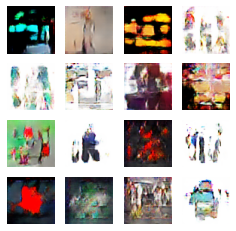

In [35]:
train(train_dataset, EPOCHS)

Now that training has finished, we can create some GIFs to show the progress of the training:

In [36]:
def gif_from_directory(directory):
    images = []
    for filename in sorted(glob.glob(f"./{directory}/*.png")):
        images.append(imageio.imread(filename))
    imageio.mimsave(f'{directory}.gif', images)

In [37]:
gif_from_directory(PREDICTIONS_FOLDER)
gif_from_directory(LOSS_FOLDER)

You can run the following cell to get 16 random outputs from your model:

In [50]:
noise = tf.random.normal([16, INPUT_SIZE])
predictions = generator(noise, training=False)
    
fig = plt.figure(figsize=(12, 12))
for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow((predictions[i].numpy() * 127.5 + 127.5).astype(int))
    plt.axis('off')
plt.show()